In [25]:
import os
import numpy as np
import skimage.io as skio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.transform import resize
from torch.utils.data import TensorDataset, DataLoader


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Part 1: Nose Tip Detection

In [27]:
def load_nose_data(root_dir, start, end, type="Training", size=(60, 80)):
    data, label = [], []

    for i in range(start, end + 1):
        gender = "m"
        name = root_dir + "{:02d}-1{}.asf".format(i, gender)
        if not os.path.exists(name):
            gender = "f"

        for j in range(1, 7):
            path = root_dir + "{:02d}-{:d}{}".format(i, j, gender)

            # jpg
            img = skio.imread(path + ".jpg", as_gray=True)
            img = resize(img, size, anti_aliasing=True)
            img = img.astype(np.float32) - 0.5

            # the nose keypoint
            asf_file = open(path + ".asf")
            points = asf_file.readlines()[16:74]
            landmark = []
            for point in points:
                x, y = point.split("\t")[2:4]
                landmark.append([float(x), float(y)])
            nose_keypoint = np.array(landmark).astype("float32")[-6]

            data.append(img)
            label.append(nose_keypoint)

    data = torch.from_numpy(np.array(data))
    label = torch.from_numpy(np.array(label))
    print(f"{type} data done.")
    return data, label


In [28]:
root_dir = "imm_face_db/"

x_train, y_train = load_nose_data(root_dir, 1, 32)
x_test, y_test = load_nose_data(root_dir, 33, 40, "Testing")

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)


Training data done.
Testing data done.


In [29]:
# CNN model
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 7)
        self.fc1 = nn.Linear(32 * 3 * 5, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [30]:
def fit_model(model, loss_func, optimizer, input_shape, epochs, train, test):
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        train_loss_per_epoch = []
        val_loss_per_epoch = []
        for inputs, labels in train:
            inputs = inputs.view(input_shape)
            labels = labels.view((inputs.shape[0], -1))

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the gradients
            optimizer.zero_grad()

            # forward + backpropagation + optimize
            pred = model(inputs)
            loss = loss_func(pred, labels)
            loss.backward()
            optimizer.step()

            train_loss_per_epoch.append(loss.item())

        model.eval()
        for inputs, labels in test:
            inputs = inputs.view(input_shape)
            labels = labels.view((inputs.shape[0], -1))

            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                pred = model(inputs)
                loss = loss_func(pred, labels)
                val_loss_per_epoch.append(loss.item())

        print(f"epoch: {epoch+1:{2}}/{epochs} - loss: {np.mean(train_loss_per_epoch):.6f} - val_loss: {np.mean(val_loss_per_epoch):.6f}")
        train_loss.append(np.mean(train_loss_per_epoch))
        val_loss.append(np.mean(val_loss_per_epoch))

    return train_loss, val_loss


In [31]:
def plot_loss(train_loss, val_loss, epochs):
    plt.plot(range(epochs), train_loss)
    plt.plot(range(epochs), val_loss)
    plt.legend(["train", "val"])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()


In [32]:
# hyperparameters
learning_rate = 0.001
batch_size = 2
epochs = 25

# dataloader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


In [33]:
# CNN
model_1 = Net_1().to(device)
print(model_1)

# optimizer
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
loss_func = nn.MSELoss().cuda()
input_shape = (-1, 1, 60, 80)


Net_1(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


In [34]:
train_loss, val_loss = fit_model(model_1, loss_func, optimizer, input_shape, epochs, train_loader, test_loader)


epoch:  1/25 - loss: 0.026408 - val_loss: 0.006322
epoch:  2/25 - loss: 0.004399 - val_loss: 0.006114
epoch:  3/25 - loss: 0.005199 - val_loss: 0.005662
epoch:  4/25 - loss: 0.003908 - val_loss: 0.004415
epoch:  5/25 - loss: 0.002884 - val_loss: 0.003437
epoch:  6/25 - loss: 0.002063 - val_loss: 0.002481
epoch:  7/25 - loss: 0.001675 - val_loss: 0.002082
epoch:  8/25 - loss: 0.001409 - val_loss: 0.001959
epoch:  9/25 - loss: 0.001304 - val_loss: 0.001976
epoch: 10/25 - loss: 0.000777 - val_loss: 0.001547
epoch: 11/25 - loss: 0.000676 - val_loss: 0.001757
epoch: 12/25 - loss: 0.000753 - val_loss: 0.001887
epoch: 13/25 - loss: 0.000643 - val_loss: 0.001345
epoch: 14/25 - loss: 0.000585 - val_loss: 0.002634
epoch: 15/25 - loss: 0.000446 - val_loss: 0.002035
epoch: 16/25 - loss: 0.000354 - val_loss: 0.001647
epoch: 17/25 - loss: 0.000414 - val_loss: 0.001213
epoch: 18/25 - loss: 0.000232 - val_loss: 0.001707
epoch: 19/25 - loss: 0.000332 - val_loss: 0.001717
epoch: 20/25 - loss: 0.000332 -

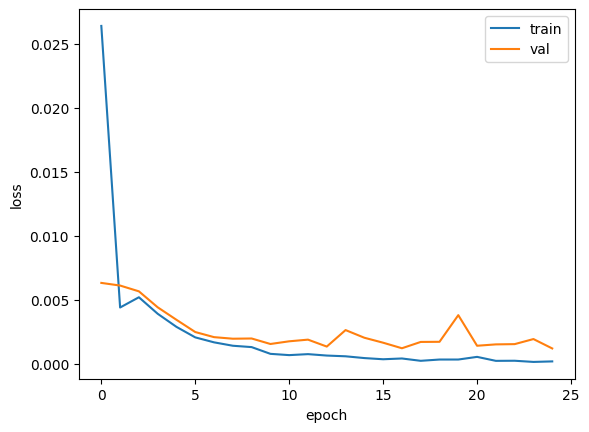

In [35]:
plot_loss(train_loss, val_loss, epochs)


In [36]:
def plot_best_and_worst_5(dataset, model, loss_func, size, dot_size=25):
    ranking = []
    for inputs, labels in dataset:
        inputs = inputs.unsqueeze(0).unsqueeze(0)
        labels = labels.unsqueeze(0).view(1, -1)

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(inputs)
            loss = loss_func(pred, labels)

        pred = pred.cpu().detach().numpy()[0].reshape(-1, 2)
        labels = labels.cpu().numpy()[0].reshape(-1, 2)
        ranking.append([inputs[0][0].cpu().numpy(), pred, labels, loss])

    ranking.sort(key=lambda x: x[3])

    # best five
    print("Best five")
    plt.figure(figsize=(16, 12))
    for i in range(5):
        arr = ranking[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(arr[0], cmap="gray")
        plt.scatter(arr[2][:, 0] * size[1], arr[2][:, 1] * size[0], s=dot_size, c="green", label="ground truth")
        plt.scatter(arr[1][:, 0] * size[1], arr[1][:, 1] * size[0], s=dot_size, c="red", label="prediction")
        plt.legend(fontsize=8)
        plt.title(f"loss: {arr[3]:.6f}")
    plt.show()

    print()

    # worst five
    print("Worst five")
    plt.figure(figsize=(16, 12))
    for i in range(1, 6):
        arr = ranking[-i]
        plt.subplot(1, 5, i)
        plt.imshow(arr[0], cmap="gray")
        plt.scatter(arr[2][:, 0] * size[1], arr[2][:, 1] * size[0], s=dot_size, c="green", label="ground truth")
        plt.scatter(arr[1][:, 0] * size[1], arr[1][:, 1] * size[0], s=dot_size, c="red", label="prediction")
        plt.legend(fontsize=8)
        plt.title(f"loss: {arr[3]:.6f}")
    plt.show()


Best five


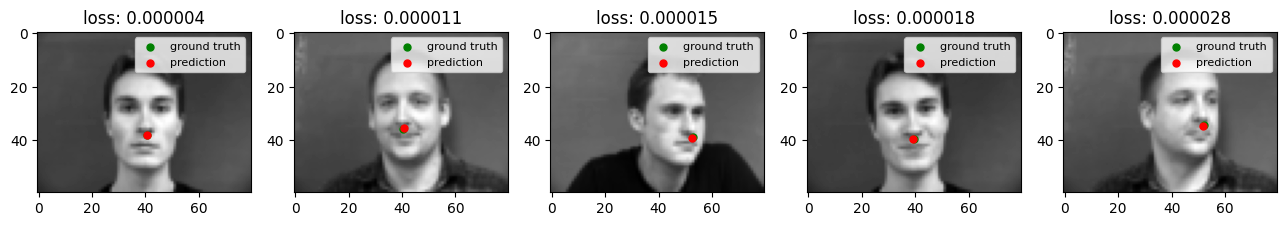


Worst five


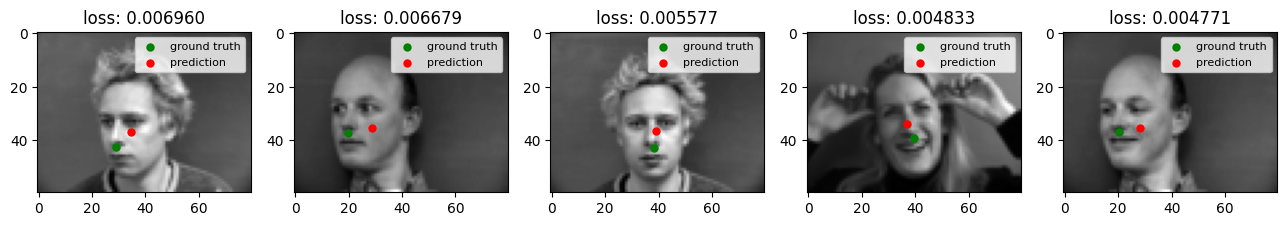

In [37]:
model_1.eval()

plot_best_and_worst_5(test, model_1, loss_func, (60 ,80))


# Part 2: Full Facial Keypoints Detection

In [38]:
import math
import random
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.transforms import functional


In [39]:
def load_full_facial(root_dir, start, end, data_type="Training", size=(120, 160)):
    data, label = [], []

    for i in range(start, end + 1):
        gender = "m"
        name = root_dir + "{:02d}-1{}.asf".format(i, gender)
        if not os.path.exists(name):
            gender = "f"

        for j in range(1, 7):
            path = root_dir + "{:02d}-{:d}{}".format(i, j, gender)

            # jpg
            img = skio.imread(path + ".jpg", as_gray=True)
            img = resize(img, size, anti_aliasing=True)
            img = img.astype(np.float32) - 0.5

            # full facial keypoints
            asf_file = open(path + ".asf")
            points = asf_file.readlines()[16:74]
            keypoints = []
            for point in points:
                x, y = point.split("\t")[2:4]
                keypoints.append([float(x), float(y)])
            keypoints = np.array(keypoints).astype("float32")

            data.append(img)
            label.append(keypoints)

            if data_type=="Training":
                data.append(img)
                data.append(img)
                label.append(keypoints)
                label.append(keypoints)

    data = torch.from_numpy(np.array(data))
    label = torch.from_numpy(np.array(label))
    print(f"{data_type} data done.")
    return data, label


In [40]:
root_dir = "imm_face_db/"

x_train, y_train = load_full_facial(root_dir, 1, 32)
x_test, y_test = load_full_facial(root_dir, 33, 40, data_type="Testing")


Training data done.
Testing data done.


In [41]:
# CNN model
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 3, 240)
        self.fc2 = nn.Linear(240, 116)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [42]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, augment=False):
        self.X = X
        self.Y = Y
        self.augment = augment

    def __len__(self):
        return self.X.shape[0]

    def doAugment(self, x, y):
        # rotation
        # determine rotation angle
        angle = random.randint(-30, 30)

        # rotate image
        x = functional.rotate(x, angle, interpolation=transforms.InterpolationMode.BILINEAR, center=[80, 60])

        # rotate keypoints
        theta = torch.tensor(-angle * math.pi / 180)
        cos, sin = torch.cos(theta), torch.sin(theta)
        rot = torch.stack([torch.stack([cos, sin]), torch.stack([-sin, cos])])
        y = ((y - 0.5) @ rot) + 0.5

        return x[0], y

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]

        if self.augment:
            x, y = self.doAugment(x.unsqueeze(0), y)

        return x, y


In [43]:
# hyperparameters
learning_rate = 0.001
batch_size = 8
epochs = 25


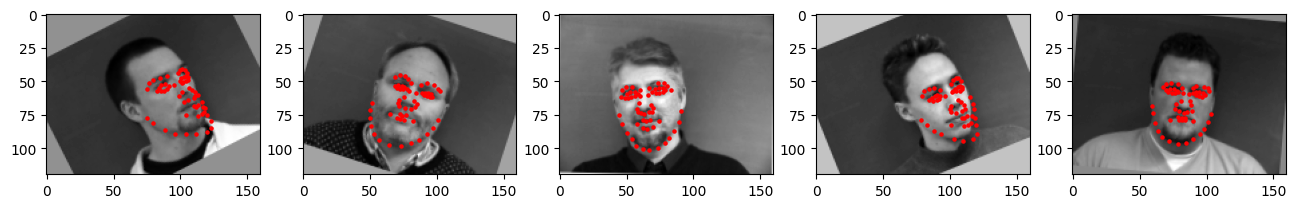

In [44]:
train = CustomDataset(x_train, y_train, augment=True)
test = CustomDataset(x_test, y_test)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

plt.figure(figsize=(16, 12))
for idx, (x, y) in enumerate(train_loader):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(x[i].numpy(), cmap="gray")
        plt.scatter(y[i, :, 0].numpy() * 160, y[i, :, 1].numpy() * 120, s=5, c="red")
    break
plt.show()


In [45]:
# CNN
model_2 = Net_2().to(device)
print(model_2)

# optimizer
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
loss_func = nn.MSELoss().cuda()
input_shape = (-1, 1, 120, 160)


Net_2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=116, bias=True)
)


In [46]:
train_loss, val_loss = fit_model(model_2, loss_func, optimizer, input_shape, epochs, train_loader, test_loader)


epoch:  1/25 - loss: 0.035291 - val_loss: 0.004435
epoch:  2/25 - loss: 0.004450 - val_loss: 0.005031
epoch:  3/25 - loss: 0.004847 - val_loss: 0.006631
epoch:  4/25 - loss: 0.004258 - val_loss: 0.004841
epoch:  5/25 - loss: 0.004879 - val_loss: 0.004282
epoch:  6/25 - loss: 0.004316 - val_loss: 0.004696
epoch:  7/25 - loss: 0.004332 - val_loss: 0.003950
epoch:  8/25 - loss: 0.004603 - val_loss: 0.003701
epoch:  9/25 - loss: 0.004171 - val_loss: 0.003975
epoch: 10/25 - loss: 0.003766 - val_loss: 0.003993
epoch: 11/25 - loss: 0.003654 - val_loss: 0.005363
epoch: 12/25 - loss: 0.002908 - val_loss: 0.003982
epoch: 13/25 - loss: 0.002944 - val_loss: 0.003800
epoch: 14/25 - loss: 0.002334 - val_loss: 0.003300
epoch: 15/25 - loss: 0.002210 - val_loss: 0.003197
epoch: 16/25 - loss: 0.001657 - val_loss: 0.002439
epoch: 17/25 - loss: 0.001370 - val_loss: 0.004238
epoch: 18/25 - loss: 0.001132 - val_loss: 0.003812
epoch: 19/25 - loss: 0.001051 - val_loss: 0.002427
epoch: 20/25 - loss: 0.000801 -

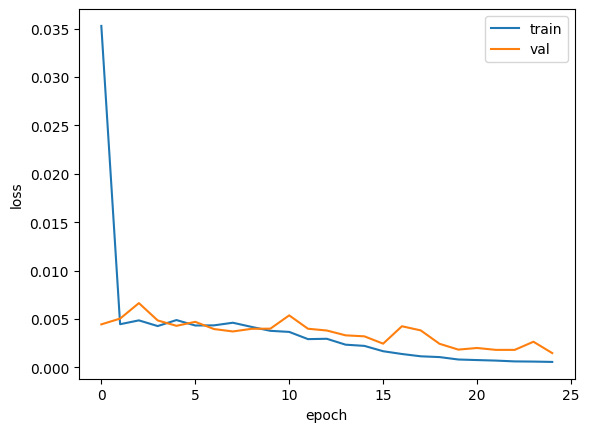

In [47]:
plot_loss(train_loss, val_loss, epochs)


Best five


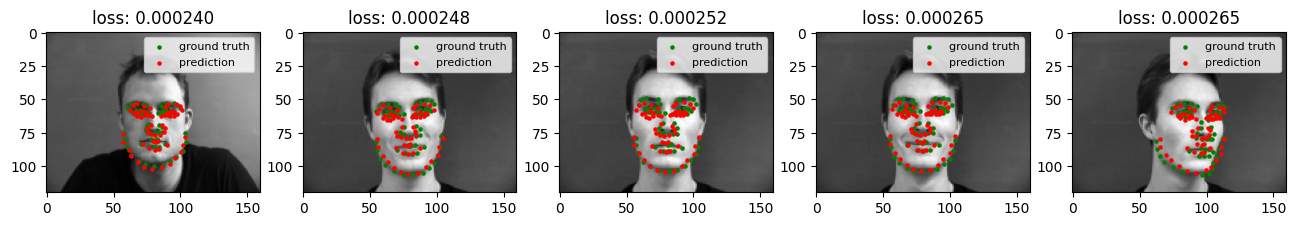


Worst five


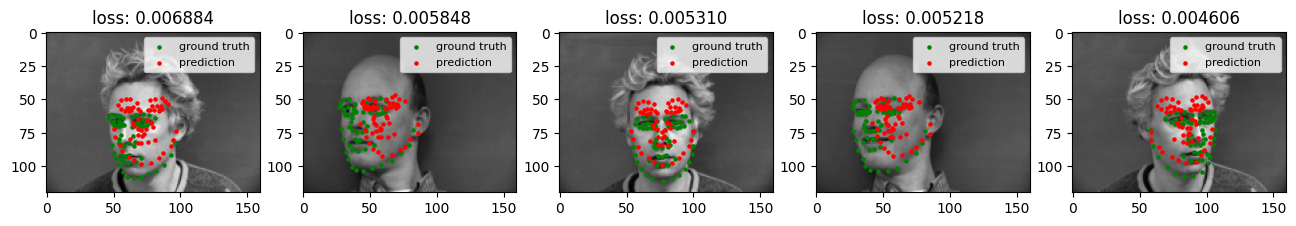

In [48]:
model_2.eval()

plot_best_and_worst_5(test, model_2, loss_func, (120, 160), 5)
